In [1]:
import galois
from py_ecc.bls12_381 import curve_order
import os
import matplotlib.pyplot as plt
import merkle_tree
from time import time
import numpy as np

from kzg import TrustedEntity, KZGProver, KZGVerifier
from verkle_tree import LeafNode, VerkleTreeNode, VerkleTreeVerifier, build_mock_tree, build_path

Generacija Galoisovega polja - to lahko traja nekaj minut.

In [2]:
GF = galois.GF(curve_order)
print("p:", curve_order)

p: 52435875175126190479447740508185965837690552500527637822603658699938581184513


# Polinomska zaveza KZG

Polinomska zaveza KZG nam omogoča, da se zavežemo polinomu, ki ga podamo kot seznam točk, za katere želimo, da jih polinom obišče.

In [3]:
SRS_degree = 20
kzg_trusted_entity = TrustedEntity(GF, curve_order, SRS_degree)
kzg_prover = KZGProver(GF, curve_order, SRS_degree, kzg_trusted_entity.SRS_1, kzg_trusted_entity.SRS_2)
kzg_verifier = KZGVerifier(GF, curve_order, SRS_degree, kzg_prover.SRS_1, kzg_prover.SRS_2)

arr = [(0, 10), (1, 20), (2, 36), (3, 50), (4, 90), (5, 44), (6, 66)]
print("Array: ", arr)
polynomial = kzg_prover.arr_to_poly(arr)
print("Polynomial: ", polynomial)
commitment = kzg_prover.commit_poly(polynomial)
print("Commitment: ", commitment)

print("\nBATCH PROOF")
points = [(0, 10), (1, 20), (5, 44)]
proof = kzg_prover.generate_batch_proof(polynomial, points)
print("Batch proof: ", proof)
kzg_verifier.verify_batch_proof(commitment, points, proof)
print("Batch proof is valid")

print("\nONE POINT PROOF")
point = (3, 50)
one_point_proof = kzg_prover.generate_one_point_proof(polynomial, point)
print("One point proof: ", one_point_proof)
kzg_verifier.verify_one_point_proof(commitment, point, one_point_proof, kzg_verifier.SRS_2)
print("One point proof is valid")

Array:  [(0, 10), (1, 20), (2, 36), (3, 50), (4, 90), (5, 44), (6, 66)]
Polynomial:  31024559478616329367006579800676696453966910229478852378373831397463660534171x^6 + 20537384443591091271117031699039503286428799729373324813853099657475944297254x^5 + 6554484396890773809930967563523245729711319062565954727825457337492322648149x^4 + 28402765719860019843034192775267398162082382604452470487243648462466731474701x^3 + 14856831299619087302510193143986023654012323208482830716404369964982598002597x^2 + 3495725011675079365296516033879064389179370166701842521506910579995905412164x + 10
Commitment:  (3760647432620598368906798702459865609176820874963321957742742660931632620038012947713614720129882786693442917635339, 2000054585663605228355308641242798743396822608000834006707027804019132779386786916775136840567894164136169628441859)

BATCH PROOF
Batch proof:  (736633675906628112250666912370978127009635036041152706613069327353086493102716297053340165624495117726499618936089, 39501220800811541207524626

# Verklovo drevo

Verklovo drevo je kriptografska podatkovna struktura, ki nam omogoča, da dokažemo, da element pripada vnaprej določeni množici.

In [4]:
l1 = [10, 20, 31, 40, 51, 60, 70, 80, 90, 100]
l2 = [30, 40, 50, 60, 70, 81, 90, 100, 110, 120]
l3 = [31, 41, 51, 61, 71, 85, 91, 101, 111, 122]
l4 = [35, 42, 56, 4431, 12171, 2385, 9145, 1012, 28111, 232322]
n1 = VerkleTreeNode(curve_order, list(map(LeafNode, l1)), kzg_prover)
n2 = VerkleTreeNode(curve_order, list(map(LeafNode, l2)), kzg_prover)
n3 = VerkleTreeNode(curve_order, list(map(LeafNode, l3)), kzg_prover)
n4 = VerkleTreeNode(curve_order, list(map(LeafNode, l4)), kzg_prover)
root = VerkleTreeNode(curve_order, [n1, n2, n3, n4], kzg_prover)

print("VERKLE TREE")
print("Number of elements: ", len(root))
print("Root Commitment: ", root.commitment)
path = {0: [(1, 20), (2, 31), (3, 40)], 1: [(1, 40), (2, 50), (3, 60)]}
print("Path", path)
proof = root.generate_proof(path)
print("Proof", proof)

verifier = VerkleTreeVerifier(root.commitment, kzg_verifier)
verifier.validate_proof(path, proof)
print("Proof is valid")

VERKLE TREE
Number of elements:  40
Root Commitment:  (1481448492875992133424738695714683015764538093175374399130063156914973139303745680202186778562969650915941632090503, 652593944875540375460624873751877355796198540665132663263357937256272973460141739124137937545232638946515082852331)
Path {0: [(1, 20), (2, 31), (3, 40)], 1: [(1, 40), (2, 50), (3, 60)]}
Proof {-1: Proof(commitment=(1481448492875992133424738695714683015764538093175374399130063156914973139303745680202186778562969650915941632090503, 652593944875540375460624873751877355796198540665132663263357937256272973460141739124137937545232638946515082852331), proof=(283578820082544149862303741017145605966982248940142483692771436721863499163369008220537165688332290955892326007273, 174980543152846328828883093076349624848206048058538831083092381551383806487319989808645966113902114359292992620183)), 0: Proof(commitment=(605079450823100875441166048717659500110785775846659561882684439948006683248852555420344767178101627154595492835496, 8

In [ ]:
SRS_degree = 30
kzg_trusted_entity = TrustedEntity(GF, curve_order, SRS_degree)
kzg_prover = KZGProver(GF, curve_order, SRS_degree, kzg_trusted_entity.SRS_1, kzg_trusted_entity.SRS_2)
kzg_verifier = KZGVerifier(GF, curve_order, SRS_degree, kzg_prover.SRS_1, kzg_prover.SRS_2)

depth = 4
width = 30
root = build_mock_tree(depth, width, kzg_prover)
verifier = VerkleTreeVerifier(root.commitment, kzg_verifier)
path = build_path(root)
print("Path", path)
proof = root.generate_proof(path)
print("Proof", proof)
print("Proof size in bytes: ", len(str(proof)))
print("Number of elements:", len(root))

verifier.validate_proof(path, proof)

Path {0: {0: [(0, 43487119373230747314603390775278843260709572329164773929397393739009339829995), (1, 35013133774757124227585197054439770649544252388521062080202117030132278105897)]}}
Proof {-1: Proof(commitment=(3473434788443930231378129685350942000983477614548362045497272016630267593655366954614275113803532817187044945121879, 1353420541875699988410963883880088734668762142226556437223634735756302473160914249714692133542474328220827965449417), proof=(1536207698930197505530975586291610184642862866235358469055069972011098653527140662460303179828494906433550629912401, 1911416223732875993367363467455049417771221825081542580372475450796940384053282275805148350140265221850885081230478)), 0: {-1: Proof(commitment=(3599659014509854323692637730415561935078050450963142429048292062508806256689623273412676887854332243457932603161202, 1425030666864740751472123383562890376481235779387386190795042473197740722284335228226100483753379413359727319034271), proof=(60959205885547300847248184019397967493877

Depth: 2, width: 10, number of elements: 10, proof size: 493 bytes
Depth: 3, width: 10, number of elements: 100, proof size: 998 bytes
Depth: 4, width: 10, number of elements: 1000, proof size: 1502 bytes
Depth: 5, width: 10, number of elements: 10000, proof size: 2008 bytes
Depth: 6, width: 10, number of elements: 100000, proof size: 2510 bytes
Depth: 2, width: 30, number of elements: 30, proof size: 494 bytes
Depth: 3, width: 30, number of elements: 900, proof size: 998 bytes
Depth: 4, width: 30, number of elements: 27000, proof size: 1503 bytes
Depth: 5, width: 30, number of elements: 810000, proof size: 2003 bytes
Depth: 6, width: 30, number of elements: 24300000, proof size: 2512 bytes
Depth: 2, width: 50, number of elements: 50, proof size: 493 bytes
Depth: 3, width: 50, number of elements: 2500, proof size: 997 bytes
Depth: 4, width: 50, number of elements: 125000, proof size: 1503 bytes
Depth: 5, width: 50, number of elements: 6250000, proof size: 2008 bytes
Depth: 6, width: 50

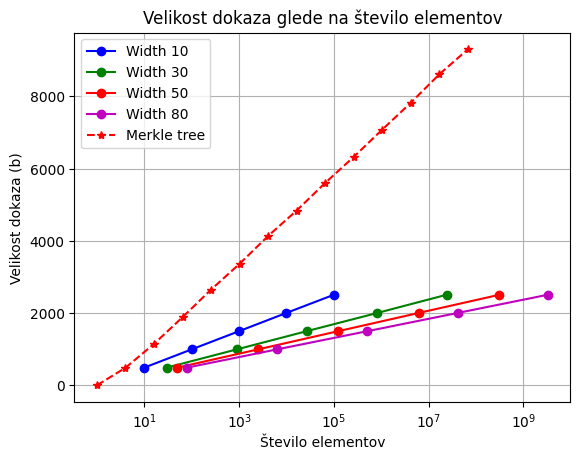

In [ ]:
depths = range(2, 7)
widths = [10, 30, 50, 80]
colors = ["b", "g", "r", "m", "y", "k"]

res = {}
res_validation = {}

for i, width in enumerate(widths):
    proof_sizes = []
    num_elements = []
    validation_times = []
    for i in depths:
        SRS_degree = width
        kzg_trusted_entity = TrustedEntity(GF, curve_order, SRS_degree)
        kzg_prover = KZGProver(GF, curve_order, SRS_degree, kzg_trusted_entity.SRS_1, kzg_trusted_entity.SRS_2)
        kzg_verifier = KZGVerifier(GF, curve_order, SRS_degree, kzg_prover.SRS_1, kzg_prover.SRS_2)

        root = build_mock_tree(i, width, kzg_prover)
        verifier = VerkleTreeVerifier(root.commitment, kzg_verifier)

        path = build_path(root)
        proof = root.generate_proof(path)
        proof_size = len(str(proof))
        proof_sizes.append(proof_size)
        num_elements.append(len(root))

        start_time = time()
        verifier.validate_proof(path, proof)
        end_time = time()
        validation_time = end_time - start_time
        validation_times.append(validation_time)

        print(f"Depth: {i}, width: {width}, number of elements: {len(root)}, proof size: {proof_size} bytes")
    
    res[width] = (proof_sizes, num_elements)
    res_validation[width] = (validation_times, num_elements)

    
for i, (width, (proof_sizes, num_elements)) in enumerate(res.items()):
    plt.plot(num_elements, proof_sizes, marker='o', color=colors[i % len(colors)], label=f'Width {width}')

# Merkle tree
merkle_depths = range(1, 28, 2)
num_elements_merkle = []
proof_sizes_merkle = []
for i in merkle_depths:
    
    tree = merkle_tree.build_tree(i)
    proof = tree.get_proof(['left'] * (i - 1))
    print("Proof length: ", len(proof))

    proof_size = len(str(proof))

    num_elements_merkle.append(len(tree))
    proof_sizes_merkle.append(proof_size)

plt.plot(num_elements_merkle, proof_sizes_merkle, marker='*', color="red", label=f'Merkle tree', linestyle='--')


plt.xlabel('Število elementov')
plt.ylabel('Velikost dokaza (b)')
plt.xscale('log')
plt.title('Velikost dokaza glede na število elementov')
plt.legend()
plt.grid(True)

output_path = os.path.join("figures", "proof_size_plot.pdf")
plt.savefig(output_path, format="pdf")

plt.show()

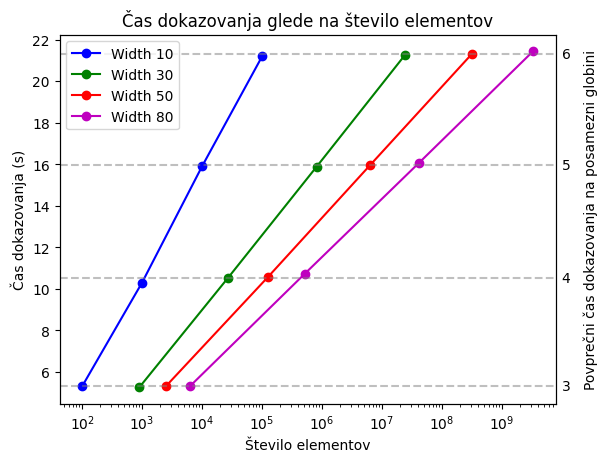

In [26]:
fig, ax = plt.subplots()

for i, (width, (validation_times, num_elements)) in enumerate(res_validation.items()):
    ax.plot(num_elements[1:], validation_times[1:], marker='o', color=colors[i % len(colors)], label=f'Width {width}')

for d in range(1, len(list(res_validation.values())[0][0])):
    avg_validation_time = np.mean([validation_times[d] for validation_times, _ in res_validation.values()])

    ax.axhline(y=avg_validation_time, color='grey', linestyle='--', alpha=0.5)
    ax.text(max(num_elements) * 3, avg_validation_time, f'{d+2}', verticalalignment='center')

ax.set_xlabel('Število elementov')
ax.set_ylabel('Čas dokazovanja (s)')
ax.set_xscale('log')
ax.set_title('Čas dokazovanja glede na število elementov')
ax.legend(loc='upper left')
ax.grid(False)

ax2 = ax.twinx()
ax2.set_ylabel('Povprečni čas dokazovanja na posamezni globini', color='black', labelpad=20)
ax2.set_yticks([])

output_path = os.path.join("figures", "validation_time_plot.pdf")
plt.savefig(output_path, format="pdf")
plt.show()